In [1]:
import OpenCity
import PreCompOsmNet

In [2]:
import osmnx

## Download geometry and OD information for a US State

In [3]:
fips=25
year=2017
geom_type='block'
centre= {'lat': 42.352927, 'lon': -71.059435}
centre_x_y=[centre['lon'], centre['lat']]

model_area_radius=5000
sim_area_radius=1000

state=OpenCity.US_State(state_fips=fips, year=year, 
#                         geom_type=geom_type
                       )
state.get_geometry()

Getting geometry (block_group) for state: Massachusetts


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


## Specify which zones are in (i) the model area (full study area) and (ii) the simulation area (bounds of the table)

In [4]:
state.subset_geom_by_distance(centre_x_y, model_area_radius, 'model_area')
state.subset_geom_by_distance(centre_x_y, sim_area_radius, 'sim_area')

	 Subsetting zones by distance
	 Subsetting zones by distance


In [5]:
all_zones=state.return_geometry()
sim_zones=state.return_geometry('sim_area')
model_zones=state.return_geometry('model_area')

## Simulate a population based on the OD matrix
### Sim Pop will only include individuals who satisfy both of these conditions:
- live AND work in the model area
- live OR work in the sim area. 

In [6]:
state.get_lodes_data()
simpop_df=state.lodes_to_pop_table(model_subset_name='model_area',
                                  sim_subset_name='sim_area')

Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data
Using 5410 of 1498059 rows in OD data
0 of 5410


## Create a osmnx networks for each mode and pre-comoute routes between all node pairs for faster route finding at simulation time

In [7]:
osmnx.utils.config(bidirectional_network_types=['walk', 'drive', 'cycle'])
print('Getting walk network')
G_walk = osmnx.graph.graph_from_point([centre['lat'], centre['lon']], 
                                      dist=sim_area_radius, network_type='walk')
for edge in list(G_walk.edges):
    G_walk.edges[edge]['speed_kph']=4.8
G_walk=PreCompOsmNet.simplify_network(G_walk)
G_walk=osmnx.add_edge_travel_times(G_walk)
fw_pred_walk=PreCompOsmNet.pre_compute_paths(G_walk)
pre_comp_walk=PreCompOsmNet.PreCompOSMNet(G_walk, fw_pred_walk)

print('Getting drive network')
G_drive = osmnx.graph.graph_from_point([centre['lat'], centre['lon']], 
                                       dist=sim_area_radius, network_type='drive')
G_drive = osmnx.add_edge_speeds(G_drive)
G_drive=PreCompOsmNet.simplify_network(G_drive)
# compute speeds
G_drive=osmnx.add_edge_travel_times(G_drive)
fw_pred_drive=PreCompOsmNet.pre_compute_paths(G_drive)
pre_comp_drive=PreCompOsmNet.PreCompOSMNet(G_drive, fw_pred_drive)

Getting walk network
	 Simplified from 14744 to 5242 edges and 4537 to 829 nodes
	 Pre-computing paths
Getting drive network
	 Simplified from 1476 to 1304 edges and 481 to 400 nodes
	 Pre-computing paths


In [8]:
networks={'drive': pre_comp_drive, 'walk': pre_comp_walk}

drive_dict={
    'target_network_id': 'drive',
    'travel_time_metric': 'travel_time'}
walk_dict={
    'target_network_id': 'walk',
    'travel_time_metric': 'travel_time'}

modes={'drive': OpenCity.Mode(drive_dict), 
       'walk': OpenCity.Mode(walk_dict)}

mob_sys=OpenCity.MobilitySystem(modes=modes, networks= networks)

# Create the Simulation

In [9]:
sim=OpenCity.Simulation(simpop_df, mob_sys, model_zones)
simpop_df=sim.get_simpop_subset(simpop_df, sample_N=1000)
simpop_df=sim.create_simple_HWH_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
all_trips_df=sim.mode_chooser(all_trips_df)
route_table=sim.get_routes_table(all_trips_df)
route_gdf=sim.route_table_to_geo(route_table)

Getting internal nodes


/Users/doorleyr/anaconda3/envs/brix/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Finding closest nodes to every zone centroid
Choosing modes


<AxesSubplot:>

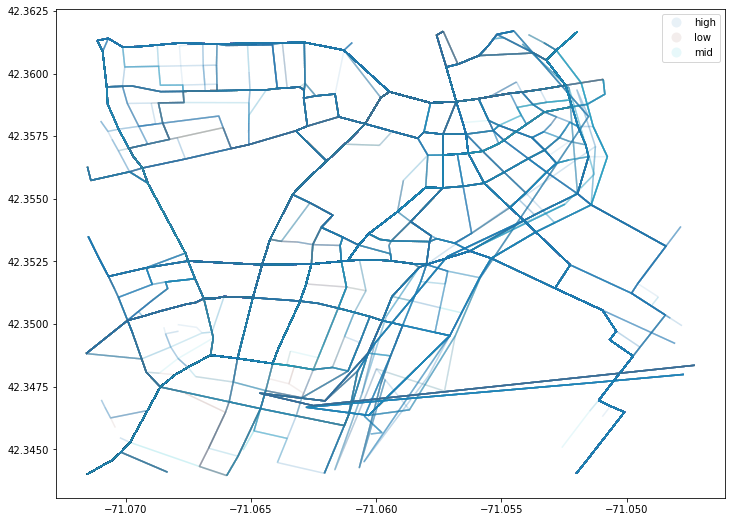

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(12,12))
route_gdf.plot(column='earnings', legend=True, alpha=0.1, ax=ax)